In [2]:
%reload_ext autoreload
%autoreload 2

from src.acnets.deep.lemon_data import LEMONDataModule
import numpy as np
import torch
import torch.nn.functional  as F
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:

datamodule = LEMONDataModule()
datamodule.setup()

ts_regions = datamodule.train[0][0].numpy().T

671


<Axes: >

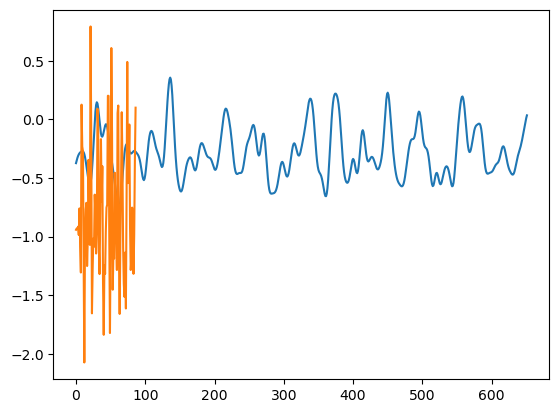

In [46]:
# Perform wavelet transform
coefs = pywt.wavedec(ts_regions, wavelet='db4', level=3)

from functools import reduce
print(reduce(lambda x, y: x+y, [c.shape[1] for c in coefs]))
# Analyze wavelet coefficients
# (e.g., extract features, detect patterns)

# Reconstruct the signal (optional)

# loss = F.mse_loss(torch.tensor(data).detach(),
#                   torch.tensor(data_recon).detach())
# # print('MSE', loss)

# n_components = 3
coefs = coefs[:1]
coefs_image = np.concatenate(coefs, axis=1)

sns.lineplot(ts_regions[1])
ts_regions_recon = pywt.waverec(coefs, wavelet='db4')

sns.lineplot(ts_regions_recon[1])

# plt.subplots(1, 3, figsize=(12, 3))
# plt.subplot(1, 3, 1)
# plt.title('original')
# sns.heatmap(ts_regions, cmap='viridis')

# plt.subplot(1, 3, 2)
# plt.title('reconstructed')
# sns.heatmap(ts_regions_recon, cmap='viridis')

# plt.subplot(1, 3, 3)
# plt.title('coefs')
# sns.heatmap(coefs_image, cmap='viridis')
# plt.show()